In [1]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler

import sys,os
sys.path.append('/'.join(os.getcwd().split('/')[:4]))
from config.get import cfg

# import standard packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [5]:
use_liquid = True
features_dir = 'liquid' if use_liquid else 'full'

In [6]:
X_train = np.load(cfg["files"][features_dir]["encoded_train_features"])
X_test = np.load(cfg["files"][features_dir]["encoded_test_features"])

In [73]:
scaler = StandardScaler()
scaler.fit(X_train)
tX_train = scaler.transform(X_train)
tX_test  = scaler.transform(X_test)

In [74]:
# /!\ this cell takes about 10 minutes to run
k_max = 100

silhouettes = []
sse = []
for k in range(2, k_max): # Try multiple k
    print(k,end="\r")
    # Cluster the data and assign the labels
    kmeans =  KMeans(n_clusters=k, random_state=42)
    labels =  kmeans.fit_predict(X_train)
    # Get the Silhouette score
    score = silhouette_score(X_train, labels)
    silhouettes.append({"k": k, "score": score})
    
    sse.append({"k": k, "sse": kmeans.inertia_})
    
# Convert to dataframes
silhouettes = pd.DataFrame(silhouettes)
sse = pd.DataFrame(sse)

In [75]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("Silhouette method", "SSE method"))

fig.add_trace(
    go.Scatter(x=silhouettes.k, y=silhouettes.score, ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=sse.k, y=sse.sse, ),
    row=1, col=2
)
fig.update_xaxes(title_text="k", range=(2, k_max), row=1, col=1)
fig.update_xaxes(title_text="k", range=(2, k_max), row=1, col=2)

fig.update_layout(height=500, width=1000, title_text="K-means: evaluation metrics for different k", showlegend=False)
fig.write_html(f"{cfg['fig_dir'][features_dir]['clustering']}kmeans_k_metrics_long.html",full_html=False, include_plotlyjs=False)
fig.show()

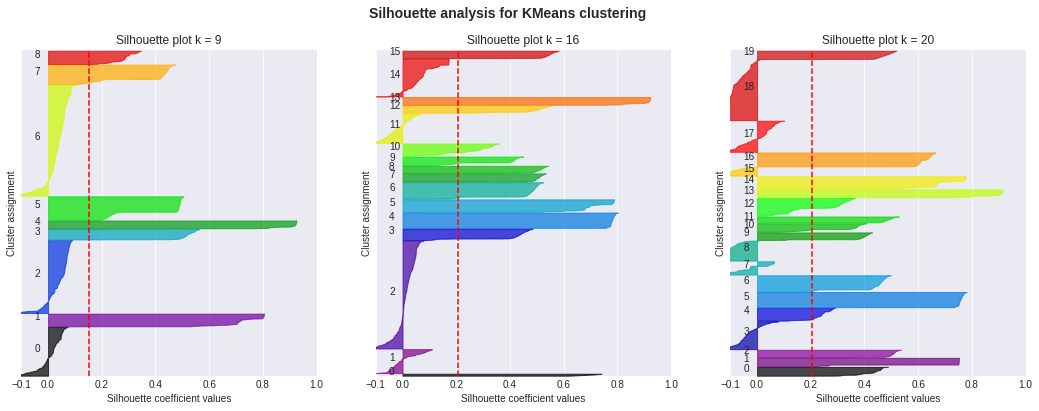

In [35]:
import matplotlib.cm as cm
import matplotlib
matplotlib.style.use('seaborn-darkgrid')
n_clusters_range = [9,16,20]
fig, axs = plt.subplots(1, len(n_clusters_range))
fig.set_size_inches(18, 6)
for j,k in enumerate(n_clusters_range):
    ax = axs[j]
    ax.set_xlim([-0.1, 1])                         # silhouettes lie within [-0.1, 1] here
    ax.set_ylim([0, len(X_train) + (k + 1) * 10])  # inserting blank space between silhouette
    clusterer = KMeans(n_clusters=k, random_state=10)# Do the clustering 
    labels = clusterer.fit_predict(X_train)
    silhouette_avg = silhouette_score(X_train, labels)             # avg silhouette
    sample_silhouette_values = silhouette_samples(X_train, labels) # scores for each sample
    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i] # aggregate per cluster
        ith_cluster_silhouette_values.sort()                                  # sort
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)                                # get color from palette
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("Silhouette plot k = %d" %k)
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster assignment")
    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.suptitle(("Silhouette analysis for KMeans clustering"),
                 fontsize=14, fontweight='bold')

fig.savefig(f"{cfg['fig_dir'][features_dir]['clustering']}silhouette-analysis.png")
plt.show()

In [36]:
# appears to be the best k value
k = 16
kmeans =  KMeans(n_clusters=k, random_state=42)
train_labels = kmeans.fit_predict(tX_train)
test_labels  = kmeans.predict(tX_test)

In [37]:
fX_train = pd.read_csv(cfg["files"][features_dir]["additional_features_train"]).drop(columns=['Unnamed: 0'])
fX_test  = pd.read_csv(cfg["files"][features_dir]["additional_features_test"]).drop(columns=['Unnamed: 0'])
fX_train

,cycle_id,revenues,costs,token1,token2,token3,profits,profitability
0,1001,1.211923e+16,1.121078e+16,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,0x0e511Aa1a137AaD267dfe3a6bFCa0b856C1a3682,0xa7DE087329BFcda5639247F96140f9DAbe3DeED1,9.084449e+14,True
1,1002,1.244307e+16,7.735328e+15,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,0xD6F0Bb2A45110f819e908a915237D652Ac7c5AA8,0xa7DE087329BFcda5639247F96140f9DAbe3DeED1,4.707741e+15,True
2,1007,1.419636e+17,1.037209e+16,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,0x0e511Aa1a137AaD267dfe3a6bFCa0b856C1a3682,0xa7DE087329BFcda5639247F96140f9DAbe3DeED1,1.315915e+17,True
3,1018,1.380598e+16,1.104995e+16,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,0x80fB784B7eD66730e8b1DBd9820aFD29931aab03,0x6B175474E89094C44Da98b954EedeAC495271d0F,2.756022e+15,True
4,1020,4.009895e+16,5.824818e+16,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,0x0e511Aa1a137AaD267dfe3a6bFCa0b856C1a3682,0xa7DE087329BFcda5639247F96140f9DAbe3DeED1,-1.814924e+16,False
...,...,...,...,...,...,...,...,...
5287,45275,5.823603e+16,2.979348e+16,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,0xf29e46887FFAE92f1ff87DfE39713875Da541373,0x9fBFed658919A896B5Dc7b00456Ce22D780f9B65,2.844256e+16,True
5288,45277,4.463634e+16,3.136590e+16,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,0x9d0A4859Aa6a2909E7421b09F701f677F27f1aB4,0x6B3595068778DD592e39A122f4f5a5cF09C90fE2,1.327044e+16,True
5289,45278,6.571211e+16,4.410904e+16,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,0x57Ab1ec28D129707052df4dF418D58a2D46d5f51,0x68A118Ef45063051Eac49c7e647CE5Ace48a68a5,2.160306e+16,True
5290,45279,2.392299e+17,2.927672e+16,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,0xdAC17F958D2ee523a2206206994597C13D831ec7,0x8fB00FDeBb4E83f2C58b3bcD6732AC1B6A7b7221,2.099532e+17,True


In [61]:
fX_train['cluster'] = train_labels
fX_train.cluster = fX_train.cluster.apply(str) # make plot look nicer
fX_test['cluster'] = test_labels
fX_test.cluster = fX_test.cluster.apply(str) # make plot look nicer

## Clustering validation


In [62]:
#simple_ordering of clusters (lengend will be easier to read)
cluster_order = {"cluster": [str(i) for i in range(k)]}

In [63]:
def bar_char_cluster(data, col, title, callback = lambda fig: 0, train=True):
    set_name = ('train' if train else 'test')
    fig = px.bar(
        data.reset_index(), 
        x='cluster', y=col, color='cluster',
        title=f"{title} ({set_name} set)",
        category_orders=cluster_order,
    )
    fig.update_xaxes(type='category')
    callback(fig)
    fig.write_html(f"{cfg['fig_dir'][features_dir]['clustering']}{title.replace(' ', '_')}_{set_name}_small.html", full_html=False, include_plotlyjs=False)
    fig.show()

In [64]:

def nb_cycles_clusters(grouper, **kwargs):
    bar_char_cluster(grouper.count(),
        'cycle_id',"Number of cycles per cluster",**kwargs)
    
def profits_clusters(grouper, **kwargs):
    bar_char_cluster(grouper.median(),
        'profits',"Profit per cluster", **kwargs)
    
def profitability_clusters(grouper, **kwargs):
    bar_char_cluster(grouper.mean(),
        'profitability',"Profitability of each cluster",
         lambda fig: fig.update_yaxes(range=(0.9, 1)), **kwargs)

def median_token_clusters(grouper, **kwargs):
    def weighted_avg(g):
        return pd.concat([g.token1, g.token2, g.token3]).value_counts().median()
    
    bar_char_cluster(grouper.apply(weighted_avg),
        0,"Median of token distribution within each cluster", **kwargs)
                     
from scipy.stats import entropy

def entropy_clusters(grouper, **kwargs):
    def weighted_avg(g):
        return entropy(pd.concat([g.token1, g.token2, g.token3]).value_counts())
        
    bar_char_cluster(grouper.apply(weighted_avg),
        0,"Entropy of token distribution within each cluster", **kwargs)

In [65]:
pipeline_metrics= [
    nb_cycles_clusters,
    profits_clusters,
    profitability_clusters,
    median_token_clusters,
    entropy_clusters
]

train_grouper = cluster_profits = fX_train.groupby('cluster')

[agg(train_grouper) for agg in pipeline_metrics]

[None, None, None, None, None]

In [72]:
def token_df(X):
    def select(i):
        df = X[[f"token{i}",'cluster']]
        df = df.rename(columns = {f"token{i}":'token'})
        #df.token = df.token.str[:20]
        return df
    return pd.concat([select(1), select(2), select(3)],axis=0)

def token_distribution(df):
    fig = px.histogram(
        df, x="token", 
        facet_col="cluster",  facet_col_wrap=4, 
        log_y=True, 
        category_orders=cluster_order,
        color='cluster'
    )
    #fig.update_xaxes(matches=None)
    fig.update_xaxes(showticklabels=False, visible=True)
    fig.update_layout(title='Token distribution per cluster')
    #fig.update_traces(showlegend=True)
    fig.show()
    
tdf = token_df(fX_train) 
token_distribution(tdf)

## Validation on test set

In [ ]:
test_grouper = fX_test.groupby('cluster')
[agg(test_grouper, train=False) for agg in pipeline_metrics]

In [ ]:
    
test_tdf = token_df(fX_test) 
token_distribution(test_tdf)